## 5. Using Pipeline
Generating categorical and numeric feature pipelines that will transform the data prep, provide feat. engineering and lastly modeling steps. Again, the goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [389]:
import pandas as pd
import cufflinks as cf
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
import pickle 
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import requests
from sklearn.preprocessing import  RobustScaler
import warnings
warnings.filterwarnings('ignore')

In [342]:
df = pd.read_csv("data.csv") 

### Function that automates training and metric process for each classifier

In [343]:
def evaluate(model, X_train_, X_test_, y_train_, y_test_):
    y_pred = model.predict(X_test_)
    y_train_pred = model.predict(X_train_)

    test_acc = model.score(X_test_, y_test_)
    train_acc = model.score(X_train_, y_train_)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)

    train_probs = model.predict_proba(X_train_)[:,1]
    train_auc = roc_auc_score(y_train_,train_probs)
    print('Train auc:', train_auc)
    test_probs = model.predict_proba(X_test_)[:,1]
    test_auc = roc_auc_score(y_test_,test_probs)
    print('Test auc:', test_auc)

    train_precision = precision_score(y_train_, y_train_pred)
    test_precision = precision_score(y_test_, y_pred)
    print('Train precision:', train_precision)
    print('Test precision:', test_precision)

    train_recall = recall_score(y_train_, y_train_pred)
    test_recall = recall_score(y_test_, y_pred)
    print('Train recall:', train_recall)
    print('Test recall:', test_recall)

    train_f1 = f1_score(y_train_, y_train_pred)
    test_f1 = f1_score(y_test_, y_pred)
    print('F1 score train:', train_f1)
    print('F1 score test:', test_f1)

    cr = classification_report(y_test_,y_pred)
    print(cr)

    plot_confusion_matrix(model, X_test_, y_test_)

    plot_roc_curve(estimator=model, X=X_test_, y=y_test_)

In [344]:
def credit_to_obj(data):
    data['Credit_History'] = data.Credit_History.astype('object')
    return data
credit_object = FunctionTransformer(credit_to_obj)

In [345]:
# creat function to select categorical and continuous variables

def num_Feats(data):
    return data[num_feats]

def cat_Feats(data):
    return data[cat_feats]

# we will start two separate pipelines for each type of features
keep_num = FunctionTransformer(num_Feats)
keep_cat = FunctionTransformer(cat_Feats)


In [346]:
# SimpleImputer for num_cols
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# SimpleImputer for cat_cols
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')

In [347]:
# create new numeric features total_income, loan_ratio, loan_term_ratio
def create_total_income(data):
    data['total_income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
    data['total_income']= data['total_income'].apply(np.log)
    return data
create_total = FunctionTransformer(create_total_income)

# def create_loan_ratio(data):
#     data['Loan_Amount_Ratio'] = data['LoanAmount'] / data['total_income']
#     return data
# Loam_Amount_Ratio = FunctionTransformer(create_loan_ratio)

# def create_term_ratio(data):
#     data['Loan_Amount_Term_ratio'] = data['LoanAmount'] / data['Loan_Amount_Term']
# Loan_Term_Ratio = FunctionTransformer(create_term_ratio)

In [348]:
#log transform Totalamount and total_income
def log_transform(data):
    data_df = pd.DataFrame(data)
    data_df.iloc[:,9] = data_df.iloc[:,9].apply(np.log)
    data_np = data_df.to_numpy()
    return data_np

logs = FunctionTransformer(log_transform)

In [349]:
Ordinal_encoder =  OrdinalEncoder()
scaler = MinMaxScaler(feature_range=(0,1))

### Proprecessing pipelines

In [350]:

cat_preprocessing = Pipeline(steps=[('credit',credit_object),
                                    ('cat_feats_filter',keep_cat),
                                    ('cat_null_transform',cat_imputer),
                                    ('encode',Ordinal_encoder)
                                   ])

num_preprocessing = Pipeline(steps=[('nums',keep_num),
                                   ('income',create_total),
                                    ('num_nulls', num_imputer),
                                    ('Scale',scaler)
                                   ])


In [351]:
# combine features back together
values_union = FeatureUnion([
    ('cat_cols', cat_preprocessing),
    ('num_cols', num_preprocessing),
])

### Pipeline Prediciton

In [352]:
label = LabelEncoder()
X = df.drop(columns=['Loan_Status','Loan_ID'],axis=1)
y = df.Loan_Status
y = label.fit_transform(y)
cat_feats = X.select_dtypes('object').columns.tolist()
num_feats = X.select_dtypes(['int','float']).columns.tolist()

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=22)

In [354]:
X_train.to_numpy()
X_test.to_numpy()

array([['Male', 'No', '0', ..., 360.0, 1.0, 'Semiurban'],
       ['Male', 'Yes', '0', ..., 360.0, 1.0, 'Urban'],
       ['Male', 'Yes', '1', ..., 360.0, nan, 'Rural'],
       ...,
       ['Male', 'No', '0', ..., 360.0, 1.0, 'Rural'],
       ['Male', 'Yes', '0', ..., 360.0, 1.0, 'Rural'],
       ['Male', 'No', '0', ..., 360.0, 1.0, 'Semiurban']], dtype=object)

### Logistic Regression

In [355]:
model = LogisticRegression()
base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

In [356]:
# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 0.8044806517311609
Test accuracy: 0.8292682926829268
Train auc: 0.7825540472599295
Test auc: 0.732905982905983
Train precision: 0.7880952380952381
Test precision: 0.8
Train recall: 0.9792899408284024
Test recall: 1.0
F1 score train: 0.8733509234828496
F1 score test: 0.888888888888889
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        39
           1       0.80      1.00      0.89        84

    accuracy                           0.83       123
   macro avg       0.90      0.73      0.76       123
weighted avg       0.86      0.83      0.81       123



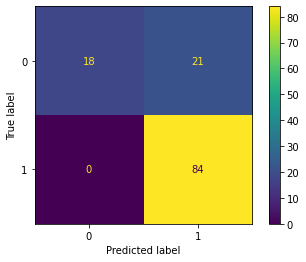

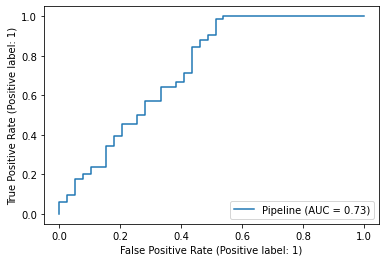

In [357]:
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

### SVM Classifier

In [358]:
model = SVC(probability=True)

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 0.8065173116089613
Test accuracy: 0.8292682926829268
Train auc: 0.8416096221526086
Test auc: 0.7518315018315019
Train precision: 0.7899761336515513
Test precision: 0.8
Train recall: 0.9792899408284024
Test recall: 1.0
F1 score train: 0.8745046235138705
F1 score test: 0.888888888888889
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        39
           1       0.80      1.00      0.89        84

    accuracy                           0.83       123
   macro avg       0.90      0.73      0.76       123
weighted avg       0.86      0.83      0.81       123



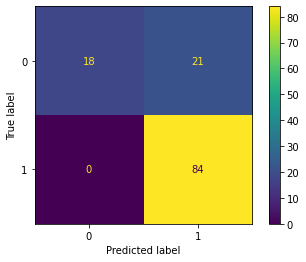

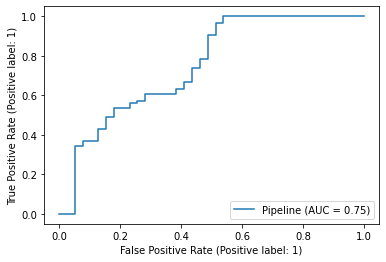

In [359]:
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

### Naive Bayes

In [360]:
model = GaussianNB()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 0.7983706720977597
Test accuracy: 0.8048780487804879
Train auc: 0.7766368874966161
Test auc: 0.7667887667887668
Train precision: 0.7980049875311721
Test precision: 0.7941176470588235
Train recall: 0.9467455621301775
Test recall: 0.9642857142857143
F1 score train: 0.8660351826792962
F1 score test: 0.8709677419354839
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        39
           1       0.79      0.96      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.71      0.74       123
weighted avg       0.81      0.80      0.79       123



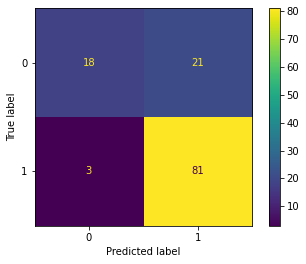

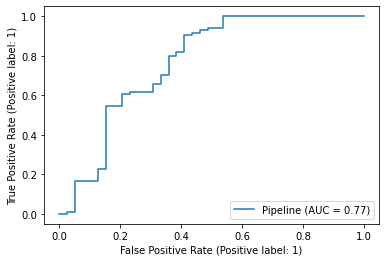

In [361]:
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

### Random Forest

In [362]:
model = RandomForestClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 1.0
Test accuracy: 0.7723577235772358
Train auc: 1.0
Test auc: 0.7994505494505494
Train precision: 1.0
Test precision: 0.7978723404255319
Train recall: 1.0
Test recall: 0.8928571428571429
F1 score train: 1.0
F1 score test: 0.8426966292134832
              precision    recall  f1-score   support

           0       0.69      0.51      0.59        39
           1       0.80      0.89      0.84        84

    accuracy                           0.77       123
   macro avg       0.74      0.70      0.72       123
weighted avg       0.76      0.77      0.76       123



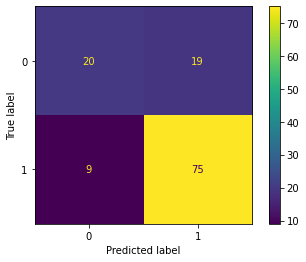

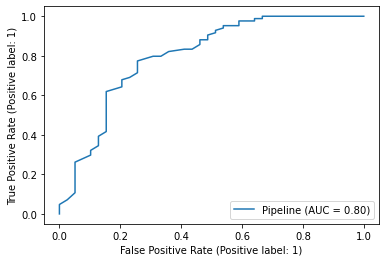

In [363]:
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

### Gradient Boosting Classifier

In [366]:
model = GradientBoostingClassifier()

base_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 0.9083503054989817
Test accuracy: 0.8048780487804879
Train auc: 0.9819584638589164
Test auc: 0.7756410256410257
Train precision: 0.8825065274151436
Test precision: 0.8061224489795918
Train recall: 1.0
Test recall: 0.9404761904761905
F1 score train: 0.9375866851595007
F1 score test: 0.8681318681318683
              precision    recall  f1-score   support

           0       0.80      0.51      0.62        39
           1       0.81      0.94      0.87        84

    accuracy                           0.80       123
   macro avg       0.80      0.73      0.75       123
weighted avg       0.80      0.80      0.79       123



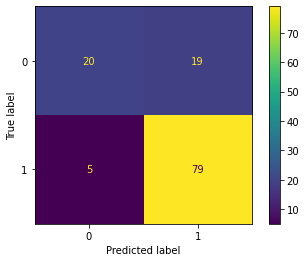

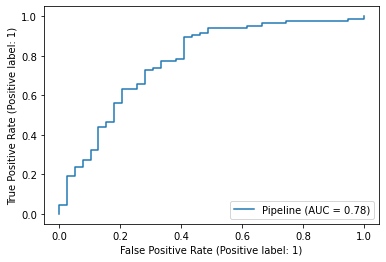

In [367]:
evaluate(base_pipeline, X_train, X_test, y_train, y_test)

### Feature Selection

In [369]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
pca = PCA(n_components=5)
kbest = SelectKBest(k=5)

feature_union = FeatureUnion([
    ('pca', pca),
    ('select_best', kbest)
])

### Random Forest with Feature Selection

In [370]:
model = RandomForestClassifier()

feat_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('features', feature_union),
    ('classifier', model)
])
# fit pipeline
feat_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder()...
                         

Train accuracy: 1.0
Test accuracy: 0.7479674796747967
Train auc: 1.0
Test auc: 0.7203907203907204
Train precision: 1.0
Test precision: 0.797752808988764
Train recall: 1.0
Test recall: 0.8452380952380952
F1 score train: 1.0
F1 score test: 0.8208092485549132
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        39
           1       0.80      0.85      0.82        84

    accuracy                           0.75       123
   macro avg       0.71      0.69      0.70       123
weighted avg       0.74      0.75      0.74       123



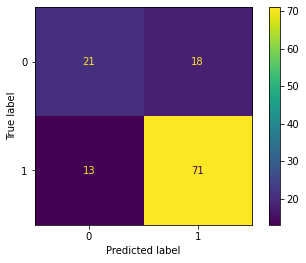

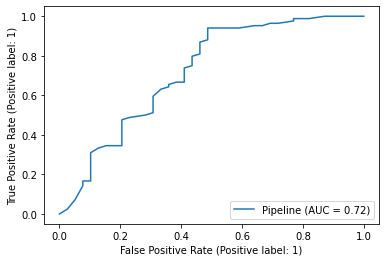

In [371]:
evaluate(feat_pipeline, X_train, X_test, y_train, y_test)

### Grid Search with Random Forest

In [376]:
# model = RandomForestClassifier()
# scalers = [StandardScaler(), MinMaxScaler(), QuantileTransformer()]

# base_pipeline = Pipeline(
#     steps=[
#     ('values', values_union),
#     ('classifier', model)
# ])

# params = {
#     'classifier__n_estimators': [15, 25, 50, 100],
#     'classifier__max_depth': [3,4, 5],
#     'classifier__random_state': [23],
#     'values__num_cols__scale': scalers
#     }

# k_folds = 5

# grid_search = GridSearchCV(base_pipeline, param_grid=params, verbose=1, refit=True, cv=k_folds)

# # fit
# grid_search.fit(X_train, y_train)

In [381]:
model = RandomForestClassifier()

final_pipeline = Pipeline(
    steps=[
    ('values', values_union),
    ('classifier', model)
])

# fit pipeline
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('credit',
                                                                  FunctionTransformer(func=<function credit_to_obj at 0x7f9aeb92bae8>)),
                                                                 ('cat_feats_filter',
                                                                  FunctionTransformer(func=<function cat_Feats at 0x7f9aeb968488>)),
                                                                 ('cat_null_transform',
                                                                  SimpleImputer(fill_value='unknown',
                                                                                strategy='constant')),
                                                                 ('encode',
                                                                  OrdinalEncoder())])),
                       

Train accuracy: 1.0
Test accuracy: 0.7723577235772358
Train auc: 1.0
Test auc: 0.8101343101343101
Train precision: 1.0
Test precision: 0.8043478260869565
Train recall: 1.0
Test recall: 0.8809523809523809
F1 score train: 1.0
F1 score test: 0.8409090909090908
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        39
           1       0.80      0.88      0.84        84

    accuracy                           0.77       123
   macro avg       0.74      0.71      0.72       123
weighted avg       0.76      0.77      0.76       123



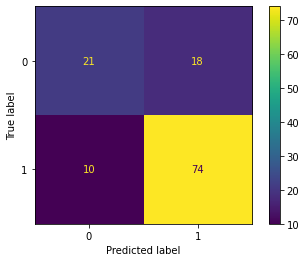

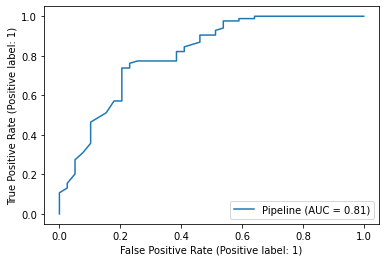

In [382]:
evaluate(final_pipeline, X_train, X_test, y_train, y_test)

### 6. Pickling the Random Forest Classifier to load via a .py file and create a web api that implements the model (sending api requests with PostMan)

In [385]:
filename = 'projectIV_model.txt'
pickle.dump(final_pipeline, open(filename, 'wb'))

In [386]:
pickle_loaded = pickle.load(open(filename, 'rb'))

In [387]:
pickle_pred = pickle_loaded.predict(X_test)

In [388]:
accuracy = accuracy_score(y_test, pickle_pred) 
print(accuracy) # pickle model working

0.7723577235772358
